In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Load AutoReg class from statsmodels.tsa.ar_model module
#
from statsmodels.tsa.ar_model import AutoReg

In [2]:
# url = 'https://www.lostarkmarket.online/api/export-item-history/North America West/achatemeow-selection-chest-3,achatemeow-selection-chest-3,armor-wagon-selection-chest-4,bike-mount-selection-chest-4,blue-crystal-0?format=csv'
# res = requests.get(url)
# res.text

In [3]:
import time
def create_item_ids_csv():
    '''
    This gets the list of the current active items and their item ID and returns it as a list.
    '''
    list_url = "https://www.lostarkmarket.online/api/export-market-live/North America East?categories=Gem Chest,Mount,Currency Exchange,Skin,Cooking?format=csv"
    res = requests.get(list_url)
    time.sleep(5)
    two_url = "https://www.lostarkmarket.online/api/export-market-live/North America East?categories=Enhancement Material,Trader,Engraving Recipe,Combat Supplies,Adventurer's Tome,Cooking?format=csv"
    restwo = requests.get(two_url)

    part_one = str(res.text)
    part_two = str(restwo.text)
    # remove the ending and starting brackets to join as 1 obj
    big_res = part_one[:-1] + ',' + part_two[1:]

    item_ids = []
    for x in big_res[1:][:-1].split(','):
        if '{"id":"' in x:
            value = x.split('{"id":')[1].replace('"','')
            item_ids.append(value)
    pd.DataFrame(item_ids,columns=['item_id']).to_csv('item_ids.csv')
    return item_ids

In [4]:
item_ids = create_item_ids_csv()

In [29]:
for x in item_ids:
    if 'shard' in x:
        print(x)

harmony-shard-pouch-l-3
harmony-shard-pouch-m-2
harmony-shard-pouch-s-1
honor-shard-pouch-l-3
honor-shard-pouch-m-2
honor-shard-pouch-s-1
life-shard-pouch-l-3
life-shard-pouch-m-2
life-shard-pouch-s-1


In [5]:
#@TODO only pull the IDS and then parse that data to a dictionary, to then send to api calls to get the historical records.
# can do many IDS at once with historical.

In [26]:
url_base = 'https://www.lostarkmarket.online/api/export-item-history/North America East/'
query_size = 5 # edit the URL if you adjust this number
remainder = len(item_ids)%query_size
sections = remainder/query_size
df_frame = []

print('Starting download')
# get the main grouping of items
if len(item_ids[:-0]) == 0:
    values_to_review = int(len(item_ids)/query_size)
else:
    #remove past the query size limit
    values_to_review = int(len(item_ids[:-remainder])/query_size)
    
for i in range(values_to_review):
    #pirnt a status value
    if i%query_size == 0:
        print(f'{i}/{values_to_review}')
        
    # construct a url
    list_url = f"{url_base}\
{item_ids[int((sections*0)+i)]},\
{item_ids[int((sections*1)+i)]},\
{item_ids[int((sections*2)+i)]},\
{item_ids[int((sections*3)+i)]},\
{item_ids[int((sections*4)+i)]}?format=csv"
    try:
        res = requests.get(list_url)
        for x in res.text.split('\n'):
            x = x.split(',')
            df_frame.append(x)
    except:
        print(f'BAD URL FOUND: {list_url}')
        continue
    # for the sake of not hitting the free public API too hard. 
    time.sleep(10)

if remainder == 0:
    pass
else:
    # don't forget the remainding items
    print(f'Starting final {remainder}')
    for i in range(int(len(item_ids[-remainder:]))):
        print(f'Starting {i}/{remainder}')
        list_url = f"{url_base}{item_ids[i]}?format=csv"
        try:
            res = requests.get(list_url)
            for x in res.text.split('\n'):
                x = x.split(',')
                df_frame.append(x)
            time.sleep(5)
        except:
            print(f'BAD URL FOUND: {list_url}')
            continue

Starting download
0/127
5/127
10/127
15/127
20/127
25/127
30/127
35/127
40/127
45/127
50/127
55/127
60/127
65/127
70/127
75/127
80/127
85/127
90/127
95/127
100/127
105/127
110/127
115/127
120/127
125/127


In [85]:
url = 'https://www.lostarkmarket.online/api/export-item-history/North America East/honor-shard-pouch-l-3?format=csv'
res = requests.get(url)
for x in res.text.split('\n'):
    x = x.split(',')
    df_frame.append(x)

In [456]:
df = pd.DataFrame(df_frame)
df.to_csv('raw.csv')

In [457]:
df.columns = df.iloc[0]
df = df.iloc[1:]

In [458]:
removed_quote_columns = []
for x in list(df.columns):
    x = x.replace('"','')
    removed_quote_columns.append(x)
df.columns = removed_quote_columns

In [459]:
df = df[df['open'].str.contains('[A-Za-z]') == False]
df = df[df['close'].str.contains('[A-Za-z]') == False]
df = df[df['high'].str.contains('[A-Za-z]') == False]
df = df[df['low'].str.contains('[A-Za-z]') == False]
df = df[df.open != '']
df = df[df.close != '']
df = df[df.high != '']
df = df[df.low != '']
df = df[df.open != 0]
df = df[df.close != 0]
df = df[df.high != 0]
df = df[df.low != 0]

In [460]:
df[[ 'open', 'close', 'high', 'low']] = df[[ 'open', 'close', 'high', 'low']].astype('float')
df.to_csv('clean_raw_timestamp.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'].astype('int64'),unit='ms')
df.to_csv('clean_db.csv')

In [461]:
one_item = '"honor-shard-pouch-s-1"'
df[df['id']==one_item]

,id,timestamp,open,close,high,low
753085,"""honor-shard-pouch-s-1""",2022-04-20 20:00:00,38.00,38.00,38.00,38.00
753086,"""honor-shard-pouch-s-1""",2022-04-20 21:00:00,36.00,36.00,36.00,36.00
753087,"""honor-shard-pouch-s-1""",2022-04-20 22:00:00,36.00,35.50,36.00,35.50
753088,"""honor-shard-pouch-s-1""",2022-04-20 23:00:00,35.50,35.00,35.50,35.00
753089,"""honor-shard-pouch-s-1""",2022-04-21 00:00:00,35.00,35.00,35.00,35.00
...,...,...,...,...,...,...
760805,"""honor-shard-pouch-s-1""",2023-03-08 12:00:00,168.67,169.00,169.00,168.67
760806,"""honor-shard-pouch-s-1""",2023-03-08 13:00:00,169.00,169.33,169.33,169.00
760807,"""honor-shard-pouch-s-1""",2023-03-08 14:00:00,169.33,169.67,169.67,169.33
760808,"""honor-shard-pouch-s-1""",2023-03-08 15:00:00,169.67,170.00,170.00,169.67


In [462]:
one_item_parse = df[df['id']==one_item]
# get the last two months of data.
recent_one_item = one_item_parse[one_item_parse.timestamp > datetime.now() - relativedelta(months=1)]

# set timestamp to be the axis
recent_one_item.index = recent_one_item.timestamp
recent_one_item.sort_index(inplace=True)
recent_one_item.drop('timestamp',axis = 1, inplace= True)

# remove outliers
from scipy import stats
recent_one_item = recent_one_item[(np.abs(stats.zscore(recent_one_item.close)) < 2.65)]
recent_one_item = recent_one_item[stats.zscore(recent_one_item.close) > -1]

C:\Users\saber\AppData\Local\Temp\ipykernel_15612\4074473352.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_one_item.drop('timestamp',axis = 1, inplace= True)


In [463]:
recent_one_item

,id,open,close,high,low
timestamp,,,,,
2023-02-10 22:00:00,"""honor-shard-pouch-s-1""",161.50,166.00,166.00,161.50
2023-02-10 23:00:00,"""honor-shard-pouch-s-1""",166.00,166.00,166.00,166.00
2023-02-11 00:00:00,"""honor-shard-pouch-s-1""",166.00,164.72,166.00,164.72
2023-02-13 21:00:00,"""honor-shard-pouch-s-1""",162.50,166.25,166.25,162.50
2023-02-13 22:00:00,"""honor-shard-pouch-s-1""",166.25,170.00,170.00,166.25
...,...,...,...,...,...
2023-03-08 12:00:00,"""honor-shard-pouch-s-1""",168.67,169.00,169.00,168.67
2023-03-08 13:00:00,"""honor-shard-pouch-s-1""",169.00,169.33,169.33,169.00
2023-03-08 14:00:00,"""honor-shard-pouch-s-1""",169.33,169.67,169.67,169.33


In [464]:
sma = recent_one_item[recent_one_item.close < 730.00]

In [465]:
sma = sma[['close']]
# sma.plot(figsize=(15,8))
window = 5
sma = sma.rolling(window=window).median()[window-1:]#.pct_change()[window:]

<AxesSubplot:xlabel='timestamp'>

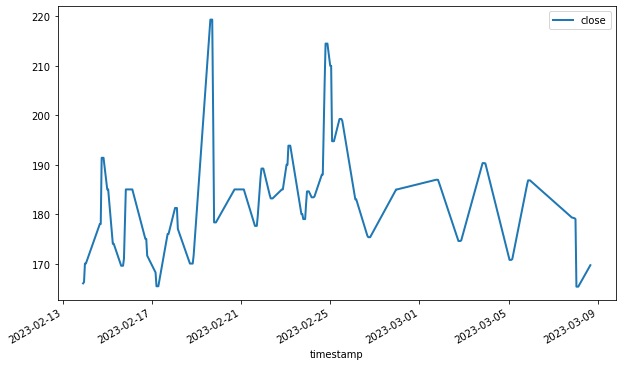

In [466]:
sma.plot(figsize=(10,6),lw=2)

In [467]:
sma

,close
timestamp,
2023-02-13 22:00:00,166.00
2023-02-13 23:00:00,166.25
2023-02-14 00:00:00,170.00
2023-02-14 01:00:00,170.00
2023-02-14 02:00:00,170.53
...,...
2023-03-08 12:00:00,168.33
2023-03-08 13:00:00,168.67
2023-03-08 14:00:00,169.00


In [468]:
# last n days of record peering
records_to_grab = 60*24
day_of_the_week = one_item_parse[-records_to_grab:]
day_of_the_week.timestamp = day_of_the_week.timestamp.dt.day_name()

C:\Users\saber\AppData\Local\Temp\ipykernel_15612\1560588022.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_of_the_week.timestamp = day_of_the_week.timestamp.dt.day_name()


<AxesSubplot:xlabel='timestamp'>

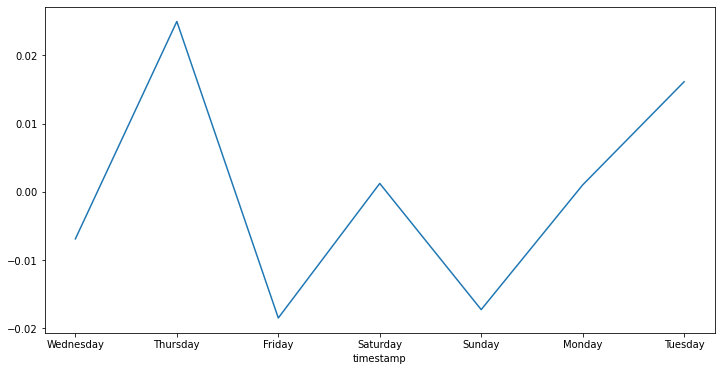

In [469]:
week_order = ['Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','Monday', 'Tuesday']
weekly_change = day_of_the_week.groupby(['timestamp']).mean().reindex(week_order).pct_change()
weekly_change.close.plot(figsize=(12,6))

### ar

In [100]:
from statsmodels.tsa.stattools import adfuller

df_stattest = adfuller(one_item_parse.close, autolag='AIC')

In [101]:
print(f'P-value: {df_stattest[1]}')

P-value: 0.025192946518545235


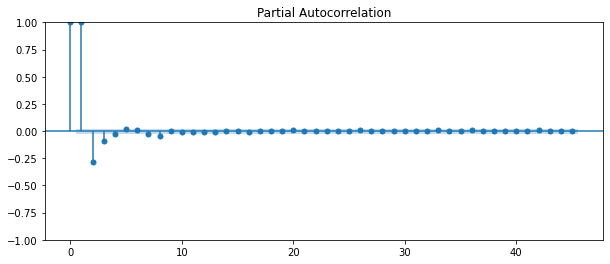

In [102]:
from statsmodels.graphics.tsaplots import plot_pacf

with plt.rc_context():
    plt.rc("figure", figsize=(10,4))
    pacf = plot_pacf(one_item_parse.close,lags=45,method="ywm")

In [103]:
last_week = -24*45
training_data = one_item_parse.close[:last_week]
test_data = one_item_parse.close[last_week:]

### Shard Bag Fair Values

In [112]:
# pouch_df = df[(df['id']=='"honor-shard-pouch-s-1"') | (df['id']=='"honor-shard-pouch-m-2"') | (df['id']=='"honor-shard-pouch-l-3"')]

In [425]:
def mean_spread_over_time(time):
    # n hour rolling average to smooth the data
    window = 12

    s_df = pouch_df[pouch_df['id']== '"honor-shard-pouch-s-1"'][['id','timestamp','close']]
    m_df = pouch_df[pouch_df['id']== '"honor-shard-pouch-m-2"'][['id','timestamp','close']]
    l_df = pouch_df[pouch_df['id']== '"honor-shard-pouch-l-3"'][['id','timestamp','close']]

    #grabbing the last n days
    records_to_grab = time*24 + window -1
    s_df = s_df[-records_to_grab:]
    m_df = m_df[-records_to_grab:]
    l_df = l_df[-records_to_grab:]

    s_df.reset_index(inplace=True)
    m_df.reset_index(inplace=True)
    l_df.reset_index(inplace=True)

    s_df['close'] = s_df.close.rolling(window=window).median()
    s_df = s_df[window-1:]
    m_df['close'] = m_df.close.rolling(window=window).median()
    m_df = m_df[window-1:]
    l_df['close'] = l_df.close.rolling(window=window).median()
    l_df = l_df[window-1:]

    s_df.close = s_df.close/500
    m_df.close = m_df.close/1000
    l_df.close = l_df.close/1500

    s_df['pct_from_lg'] = percentage_difference(s_df.close,l_df.close)

    average_spread = s_df.describe().iloc[1,2]
    return(average_spread)

In [470]:
# n hour rolling average to smooth the data
window = 24

s_df = pouch_df[pouch_df['id']== '"honor-shard-pouch-s-1"'][['id','timestamp','close']]
m_df = pouch_df[pouch_df['id']== '"honor-shard-pouch-m-2"'][['id','timestamp','close']]
l_df = pouch_df[pouch_df['id']== '"honor-shard-pouch-l-3"'][['id','timestamp','close']]

#grabbing the last n days
records_to_grab = 180*24 + window -1
s_df = s_df[-records_to_grab:]
m_df = m_df[-records_to_grab:]
l_df = l_df[-records_to_grab:]

s_df.reset_index(inplace=True)
m_df.reset_index(inplace=True)
l_df.reset_index(inplace=True)

# clean the outliers 
# s_df = s_df[(np.abs(stats.zscore(s_df.close)) < 3)]
# s_df = s_df[stats.zscore(s_df.close) > -1.3]

# m_df = m_df[(np.abs(stats.zscore(m_df.close)) < 3)]
# m_df = m_df[stats.zscore(m_df.close) > -1.3]

# l_df = l_df[(np.abs(stats.zscore(l_df.close)) < 3)]
# l_df = l_df[stats.zscore(l_df.close) > -1.3]


s_df['close'] = s_df.close.rolling(window=window).median()
s_df = s_df[window-1:]
m_df['close'] = m_df.close.rolling(window=window).median()
m_df = m_df[window-1:]
l_df['close'] = l_df.close.rolling(window=window).median()
l_df = l_df[window-1:]

##### adjust the price to the price per shard

In [471]:
s_df.close = s_df.close/500
m_df.close = m_df.close/1000
l_df.close = l_df.close/1500

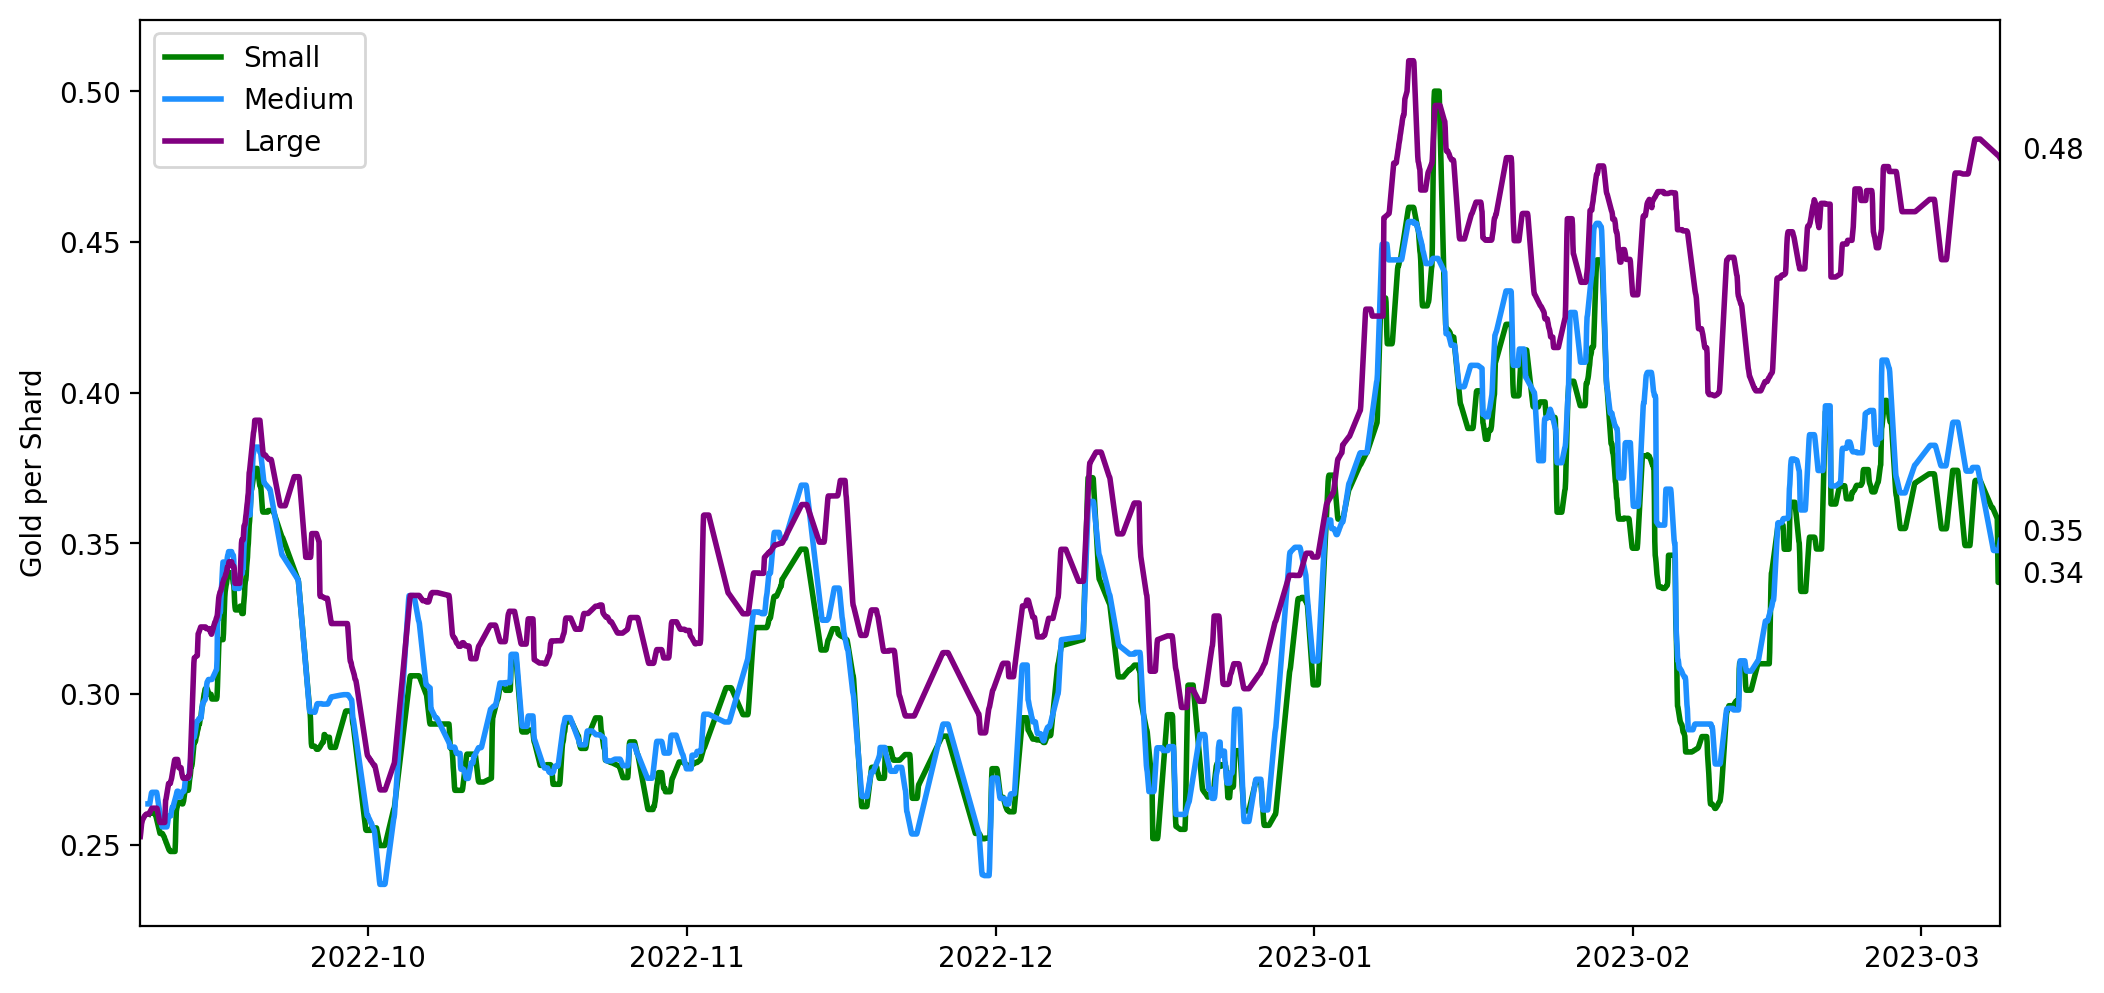

In [472]:
# Data
from matplotlib.pyplot import figure
figure(figsize=(12, 6), dpi=200)

s_end = s_df.close.iloc[-1]
m_end = m_df.close.iloc[-1]
l_end = l_df.close.iloc[-1]


# multiple line plots
plt.plot('timestamp', 'close', data=s_df, color='green', linewidth=2, label="Small")
plt.plot('timestamp', 'close', data=m_df, color='dodgerblue', linewidth=2, label="Medium")
plt.plot('timestamp', 'close', data=l_df, color='purple', linewidth=2, label="Large")

# add ending values
for var in (s_end,m_end,l_end):
    plt.annotate('%0.2f' % var.max(), xy=(1, var.max()), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')

min_time = l_df.timestamp.iloc[0]
max_time = l_df.timestamp.iloc[-1]
plt.xlim(min_time,max_time)
# show legend
plt.legend()
plt.ylabel('Gold per Shard')
# show graph
plt.show()

In [474]:
def percentage_change(col1,col2):
    return ((col2.sub(col1)).div(col1)).mul(100)

def percentage_difference(col1,col2):
    return ((abs(col1.sub(col2))).div(col1.add(col2)/2).mul(100))

s_df['pct_from_lg'] = percentage_difference(s_df.close,l_df.close)


In [475]:
s_df.tail(1)

,index,id,timestamp,close,pct_from_lg
4342,760809,"""honor-shard-pouch-s-1""",2023-03-08 16:00:00,0.337,34.533552


In [476]:
l_df.tail()

,index,id,timestamp,close
4338,776257,"""honor-shard-pouch-l-3""",2023-03-08 12:00:00,0.478557
4339,776258,"""honor-shard-pouch-l-3""",2023-03-08 13:00:00,0.478333
4340,776259,"""honor-shard-pouch-l-3""",2023-03-08 14:00:00,0.478110
4341,776260,"""honor-shard-pouch-l-3""",2023-03-08 15:00:00,0.477890
4342,776261,"""honor-shard-pouch-l-3""",2023-03-08 16:00:00,0.477667


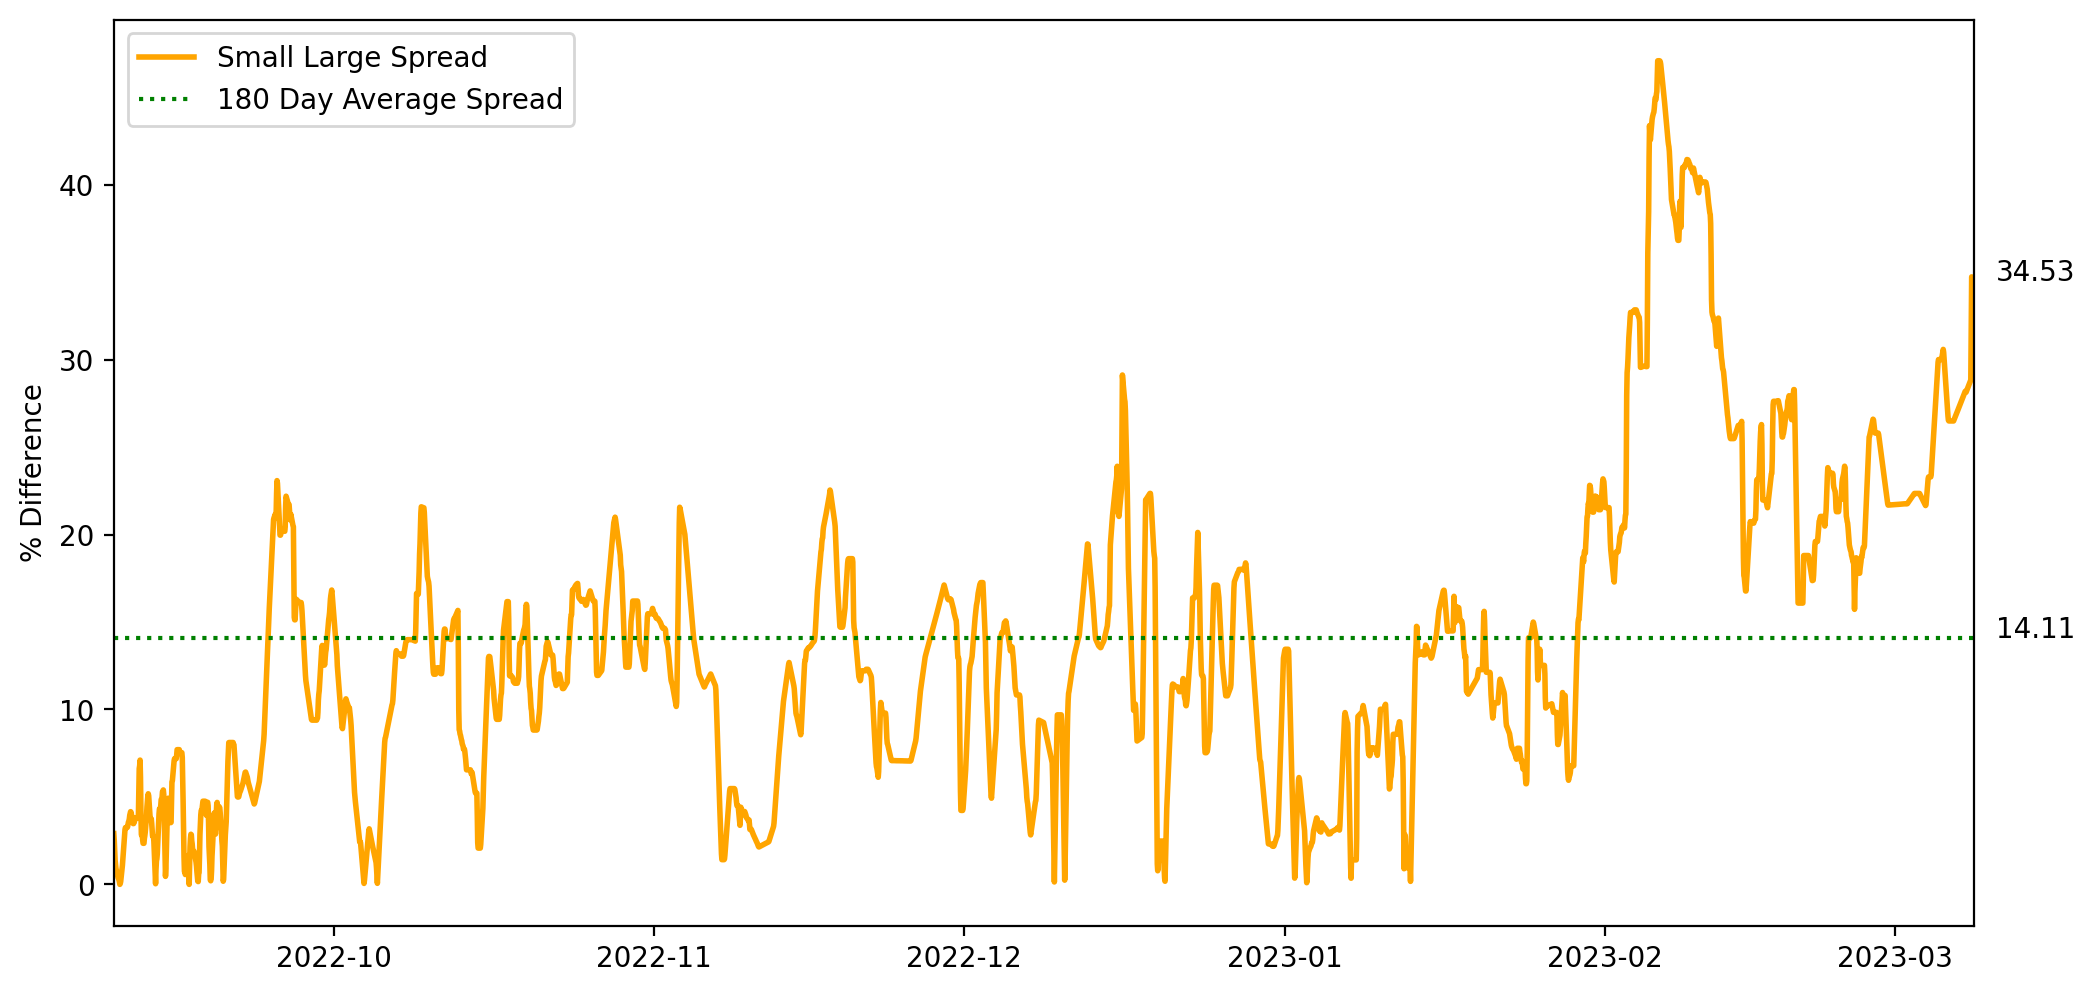

In [477]:
# Data
from matplotlib.pyplot import figure
figure(figsize=(12, 6), dpi=200)

# multiple line plots
plt.plot('timestamp', 'pct_from_lg', data=s_df, color='orange', linewidth=2, label="Small Large Spread")

# add ending values
spread_one = mean_spread_over_time(180)
plt.axhline(y = spread_one, color = 'green', linestyle = 'dotted', label = '180 Day Average Spread')

s_end = s_df.pct_from_lg.iloc[-1]
for var in ([s_end,spread_two]):
    plt.annotate('%0.2f' % var.max(), xy=(1, var.max()), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')


min_time = s_df.timestamp.iloc[0]
max_time = s_df.timestamp.iloc[-1]
plt.xlim(min_time,max_time)

# show legend
plt.legend()
plt.ylabel('% Difference')
# show graph
plt.show()

In [447]:
s_end - spread_one

20.153062868432784